In [1]:
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import math
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Генерация выборки

In [2]:
number_points = 70
a = scipy.stats.multivariate_normal.rvs(size=number_points, mean=[0, 3], cov=[[2, 1.5], [1.5, 2]])
b = scipy.stats.multivariate_normal.rvs(size=number_points, mean=[2.5, 0], cov=[[2, -0.5], [-0.5, 2]])
c = scipy.stats.multivariate_normal.rvs(size=number_points, mean=[3.5, 3.5], cov=[[3, -1.5], [-1.5, 3]])
X_train = np.vstack([a, b, c])
Y_train = np.hstack([np.zeros(len(a)), np.ones(len(b)), np.ones(len(c)) * 2])

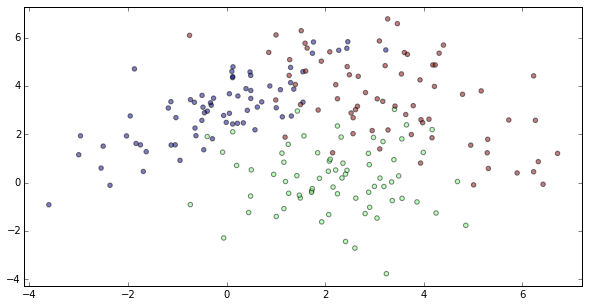

In [3]:
plt.figure(figsize=(10, 5))
plt.scatter(X_train[:, 0], X_train[:, 1], c=Y_train, alpha=0.5)
plt.xlim((min(X_train[:, 0]) - 0.5, max(X_train[:, 0]) + 0.5))
plt.ylim((min(X_train[:, 1]) - 0.5, max(X_train[:, 1]) + 0.5))
plt.show()

# Метрики

In [4]:
def l2_norm(x, y):
    return (sum([(a - b) ** 2 for a,b in zip(x,y)])) ** 0.5

In [5]:
def l1_norm(x, y):
    return (sum([math.fabs((a - b)) for a,b in zip(x,y)]))

# Функции ядер

In [6]:
def window(rho):
    if -1 < rho < 1:
        return 0.5
    else:
        return 0

In [7]:
def norm_kernel(rho):
    return 1./(2 * np.pi) ** 0.5 * np.exp(- rho ** 2 /2.)

# Метод парзеновского окна

In [8]:
def predict_class(point, X, classes_spliter, kernel, norm):
    classes_indexes = [0] + classes_spliter + [len(X)]
    probability_of_class = []
    for index in range(1, len(classes_indexes)):
        probability_of_class.append(0)
        for x in X[classes_indexes[index - 1]:classes_indexes[index]]:
            probability_of_class[-1] += kernel(norm(point, x))
    if max(probability_of_class) == 0:
        return -1
    return probability_of_class.index(max(probability_of_class))

In [9]:
def generate_grid(train_sample, border=1, step=0.05):
    return np.meshgrid(np.arange(min(train_sample[:, 0]) - border, max(train_sample[:, 1]) + border, step), 
                       np.arange(min(train_sample[:, 1]) - border, max(train_sample[:, 1]) + border, step))

In [10]:
col = 'b' * number_points + 'y' * number_points + 'r' * number_points

In [11]:
def create_picture(X_train, Y_train, kernel, norm):
    grid = generate_grid(X_train)
    grid = generate_grid(X_train)
    
    grid_ravel = np.c_[grid[0].ravel(), grid[1].ravel(0)]
    grid_prediction = [predict_class(x, X_train, [list(Y_train).count(0), len(Y_train) - list(Y_train).count(2)], kernel, norm)
                       for x in grid_ravel]

    grid_prediction = np.array(grid_prediction).reshape(grid[0].shape)

    plt.figure(figsize=(12,8))

    plt.pcolor(grid[0], grid[1], grid_prediction)
    plt.scatter(X_train[:, 0], X_train[:, 1], alpha=1, c=col)
    plt.xlim((min(grid_ravel[:, 0]), max(grid_ravel[:, 0])))
    plt.ylim((min(grid_ravel[:, 1]), max(grid_ravel[:, 1])))
    plt.show()

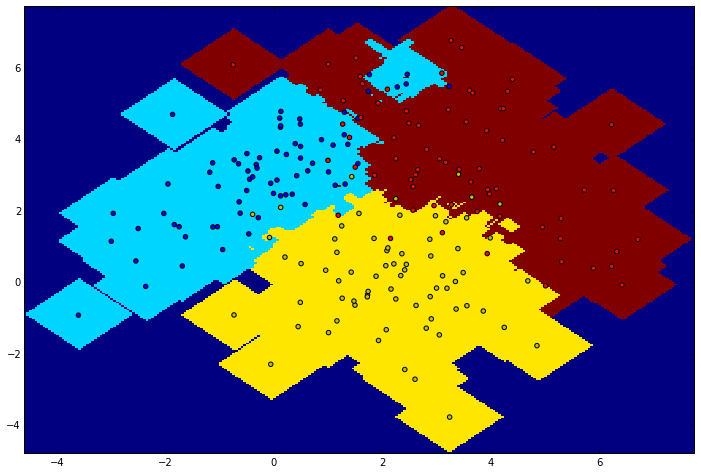

CPU times: user 1min 46s, sys: 505 ms, total: 1min 46s
Wall time: 1min 46s


In [12]:
%%time
create_picture(X_train, Y_train, window, l1_norm)

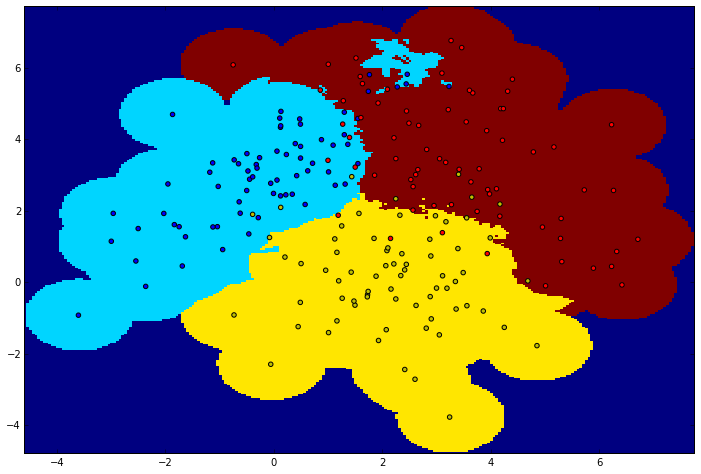

CPU times: user 1min 50s, sys: 631 ms, total: 1min 50s
Wall time: 1min 49s


In [13]:
%%time
create_picture(X_train, Y_train, window, l2_norm)

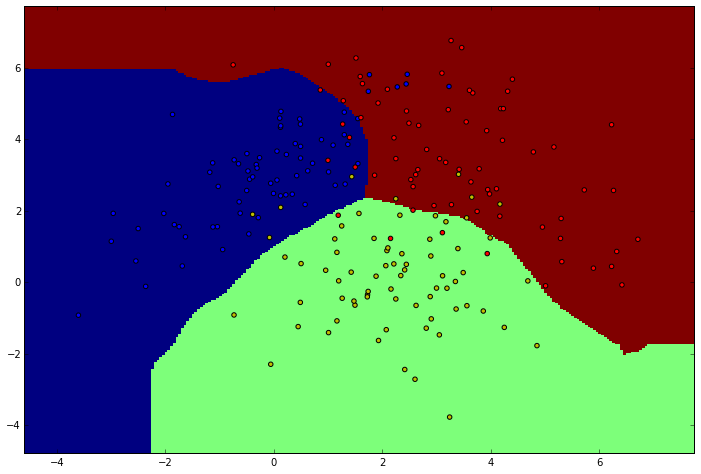

CPU times: user 2min 18s, sys: 799 ms, total: 2min 18s
Wall time: 2min 18s


In [15]:
%%time
create_picture(X_train, Y_train, norm_kernel, l1_norm)

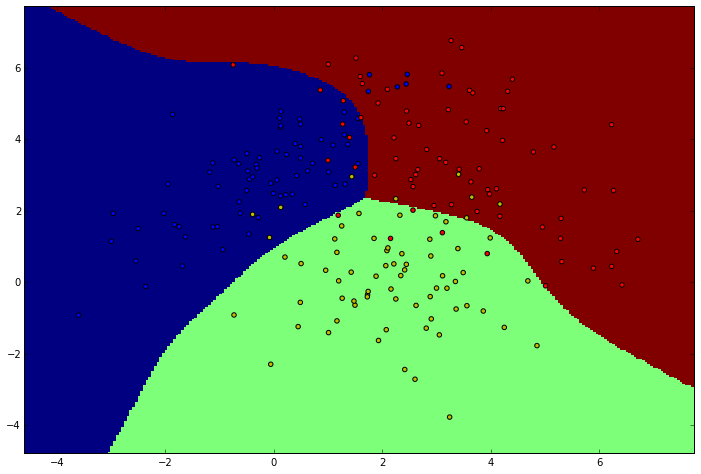

CPU times: user 2min 14s, sys: 644 ms, total: 2min 15s
Wall time: 2min 14s


In [14]:
%%time
create_picture(X_train, Y_train, norm_kernel, l2_norm)

# Качество работы

In [16]:
def calc_mistake(X_train, Y_train, X_test, Y_test, kernel, norm):
    mistake_counter = 0.
    for x, y in zip(X_test, Y_test):
        if predict_class(x, X_train, [list(Y_train).count(0), len(Y_train) - list(Y_train).count(2)], kernel, norm) != y:
            mistake_counter += 1
            
    return mistake_counter/len(X_test)

In [17]:
a = scipy.stats.multivariate_normal.rvs(size=150, mean=[0, 3], cov=[[2, 1.5], [1.5, 2]])
b = scipy.stats.multivariate_normal.rvs(size=200, mean=[2.5, 0], cov=[[2, -0.5], [-0.5, 2]])
c = scipy.stats.multivariate_normal.rvs(size=250, mean=[3.5, 3.5], cov=[[3, -1.5], [-1.5, 3]])
X_test = np.vstack([a, b, c])
Y_test = np.hstack([np.zeros(len(a)), np.ones(len(b)), np.ones(len(c)) * 2])

В метрике $L^2:$

In [18]:
calc_mistake(X_train, Y_train, X_test, Y_test, window, l2_norm)

0.19833333333333333

In [19]:
calc_mistake(X_train, Y_train, X_test, Y_test, norm_kernel, l2_norm)

0.165

В метрике $L^1$:

In [20]:
calc_mistake(X_train, Y_train, X_test, Y_test, window, l1_norm)

0.21333333333333335

In [21]:
calc_mistake(X_train, Y_train, X_test, Y_test, norm_kernel, l1_norm)

0.16166666666666665

#kNN

In [22]:
from sklearn.neighbors import KNeighborsClassifier
import sklearn.metrics

In [29]:
model = KNeighborsClassifier(n_neighbors=15, algorithm='brute')
model.fit(X_train, Y_train)

KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
           metric_params=None, n_neighbors=15, p=2, weights='uniform')

In [30]:
sklearn.metrics.hamming_loss(Y_test, model.predict(X_test), classes=[0,1,2])

0.15833333333333333